In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
# Align the kernel with the UI
!pip install --quiet "ipywidgets>=8,<9"  # e.g. 8.1.2 as of today
# optional but avoids leftover cache problems
import os, shutil, sys, importlib, pkg_resources; importlib.invalidate_caches()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
!pip install datasets
!pip install tokenizers
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
!pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
from datasets import load_dataset

dataset = load_dataset("wikiann", "hi")

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
dataset["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'spans': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [26]:
label_names = dataset["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [27]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True)
  total_adjusted_labels = []
  #print(len(tokenized_samples["input_ids"]))
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []
   
    for wid in word_ids_list:
      if(wid is None):
        adjusted_label_ids.append(-100)
      elif(wid!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = wid
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])
        
    total_adjusted_labels.append(adjusted_label_ids)
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [28]:
tokenized_dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

In [29]:
tokenized_dataset["train"] = tokenized_dataset["train"].select(range(5000))
tokenized_dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

In [30]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [31]:
data_collator

DataCollatorForTokenClassification(tokenizer=BertTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

In [32]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
from datasets import load_metric
metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    flattened_results = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    for k in results.keys():
      if(k not in flattened_results.keys()):
        flattened_results[k+"_f1"]=results[k]["f1"]

    return flattened_results
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)

    flattened_results = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
        "accuracy": results["overall_accuracy"]  # required for logging eval_accuracy
    }

    for k in results:
        if k not in flattened_results:
            flattened_results[f"{k}_f1"] = results[k]["f1"]

    return flattened_results

In [33]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(label_names))
training_args = TrainingArguments(
    output_dir="./fine_tune_bert_output",
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps = 250,
    report_to="none",
    run_name = "hindi_ner_final_200-2",
    save_strategy='no',
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Accuracy,Loc F1,Org F1,Per F1
250,0.580800,0.377416,0.798198,0.814980,0.806502,0.881212,0.881212,0.770627,0.719690,0.904762
500,0.287400,0.346778,0.844716,0.854928,0.849791,0.910262,0.910262,0.826677,0.782609,0.912874
750,0.186900,0.348669,0.863577,0.866754,0.865163,0.915372,0.915372,0.839390,0.792871,0.937437
1000,0.154100,0.320215,0.876591,0.886728,0.881631,0.924612,0.924612,0.862364,0.821866,0.941216
1250,0.105200,0.326643,0.870968,0.886991,0.878906,0.922722,0.922722,0.862495,0.815825,0.939435
1500,0.075300,0.355608,0.877188,0.895401,0.886201,0.927201,0.927201,0.873315,0.825609,0.939647
1750,0.055600,0.380504,0.883871,0.900131,0.891927,0.931961,0.931961,0.881196,0.841360,0.936424
2000,0.036000,0.382616,0.896552,0.901971,0.899253,0.933711,0.933711,0.886977,0.842850,0.950287
2250,0.027000,0.395638,0.905477,0.903811,0.904643,0.939171,0.939171,0.883614,0.859804,0.954253
2500,0.023000,0.425317,0.899764,0.901183,0.900473,0.934761,0.934761,0.882284,0.850683,0.952316


TrainOutput(global_step=3130, training_loss=0.1249632296089928, metrics={'train_runtime': 348.0121, 'train_samples_per_second': 143.673, 'train_steps_per_second': 8.994, 'total_flos': 920287949060832.0, 'train_loss': 0.1249632296089928, 'epoch': 10.0})

In [34]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
[label_names[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

true_labels = [[label_names[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'LOC': {'precision': 0.9147286821705426,
  'recall': 0.8887029288702929,
  'f1': 0.901528013582343,
  'number': 1195},
 'ORG': {'precision': 0.8779527559055118,
  'recall': 0.9046653144016227,
  'f1': 0.891108891108891,
  'number': 986},
 'PER': {'precision': 0.9175324675324675,
  'recall': 0.9540850776502363,
  'f1': 0.9354518371400199,
  'number': 1481},
 'overall_precision': 0.9058380414312618,
 'overall_recall': 0.9194429273620972,
 'overall_f1': 0.9125897818132538,
 'overall_accuracy': 0.9486066377258087}

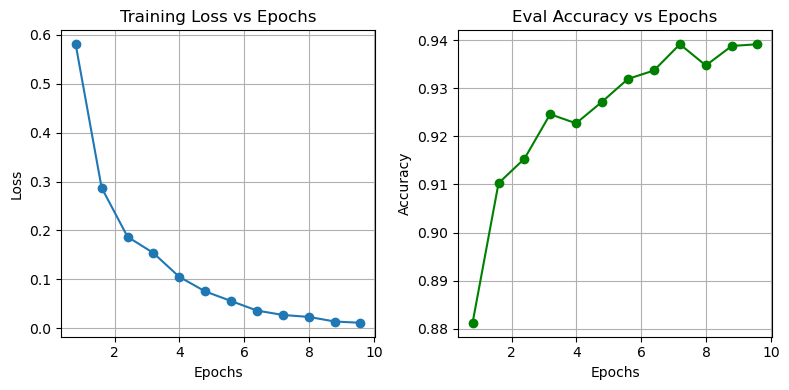

In [35]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

epochs = []
train_loss = []
eval_loss = []
eval_accuracy = []

for log in logs:
    if "loss" in log and "epoch" in log:
        epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label="Evaluation Accuracy", marker="o", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Eval Accuracy vs Epochs")
plt.grid(True)

plt.tight_layout()
plt.show()


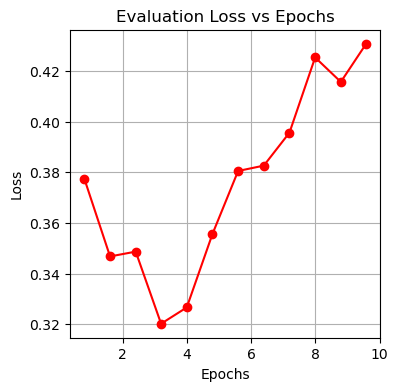

In [40]:
plt.figure(figsize=(4, 4))
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Evaluation Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evaluation Loss vs Epochs")
plt.grid(True)
plt.show()

Confusion matrix:
[[1073   58   16    8   11    4   25]
 [  27  900   36    0    5    0   18]
 [   4   16 1417    0    5    8   31]
 [   3    0    0  738   87   25   14]
 [   9    0    0   18 2501   53   21]
 [   1    0   11    5   42 1806    9]
 [  33   23   54    8   20   26 5113]]
Heatmap


Text(0.5, 1.0, 'Confusion matrix')

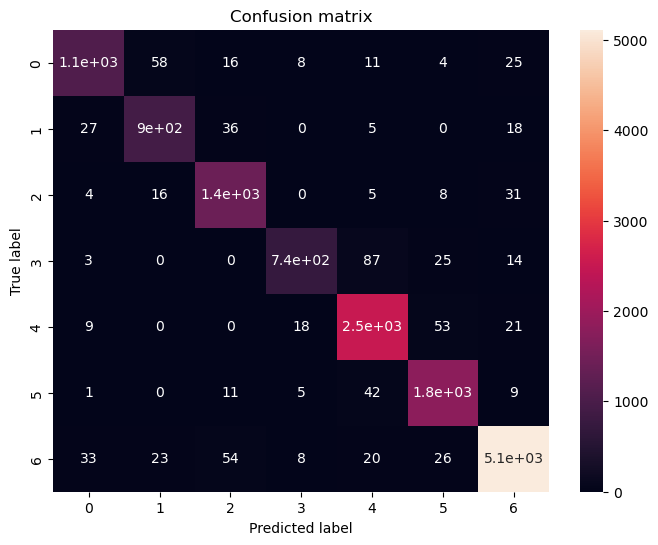

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.concatenate(true_labels)
y_pred = np.concatenate(true_predictions)

label_names = np.unique(np.concatenate((y_true, y_pred)))

cm = confusion_matrix(y_true, y_pred, labels=label_names)

print("Confusion matrix:")
print(cm)

print("Heatmap")
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True) 

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")

In [38]:
def get_entities(sentence, tokenizer, model, label_list):
    import torch

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    words = sentence.strip().split()
    tokens = tokenizer(words, return_tensors="pt", is_split_into_words=True, truncation=True, return_offsets_mapping=True)
    word_ids = tokens.word_ids()


    input_tokens = {k: v.to(device) for k, v in tokens.items() if k != "offset_mapping"}

    with torch.no_grad():
        outputs = model(**input_tokens)

    logits = outputs.logits
    predictions = logits.argmax(dim=-1).squeeze(0).cpu().numpy()

    results = []
    seen = set()
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id in seen:
            continue
        seen.add(word_id)
        label_idx = predictions[idx]
        label = label_list[label_idx]
        if label != "O":
            results.append((words[word_id], label))

    return results

label_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

# Test
sentence = "राहुल गांधी ने दिल्ली में एक रैली को संबोधित किया।"
entities = get_entities(sentence, tokenizer, model, label_list)

print("Named Entities:")
for token, label in entities:
    print(f"{token} → {label}")


Named Entities:
राहुल → B-PER
गांधी → I-PER
दिल्ली → B-LOC
